In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load your data
df = pd.read_csv('../raw_data/accepted_2007_to_2018Q4.csv', nrows=15000)

# Select key columns (same as before)
key_columns = [
    'loan_amnt', 'int_rate', 'grade', 'emp_length', 'annual_inc',
    'dti', 'fico_range_low', 'revol_util', 'purpose',
    'home_ownership', 'loan_status'
]
df_subset = df[key_columns].copy()

/tmp/ipykernel_6441/2475043372.py:12: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../raw_data/accepted_2007_to_2018Q4.csv', nrows=15000)


In [2]:
df_subset.head()

,loan_amnt,int_rate,grade,emp_length,annual_inc,dti,fico_range_low,revol_util,purpose,home_ownership,loan_status
0,3600.0,13.99,C,10+ years,55000.0,5.91,675.0,29.7,debt_consolidation,MORTGAGE,Fully Paid
1,24700.0,11.99,C,10+ years,65000.0,16.06,715.0,19.2,small_business,MORTGAGE,Fully Paid
2,20000.0,10.78,B,10+ years,63000.0,10.78,695.0,56.2,home_improvement,MORTGAGE,Fully Paid
3,35000.0,14.85,C,10+ years,110000.0,17.06,785.0,11.6,debt_consolidation,MORTGAGE,Current
4,10400.0,22.45,F,3 years,104433.0,25.37,695.0,64.5,major_purchase,MORTGAGE,Fully Paid


#### Understanding the Target Variable (Loan status)

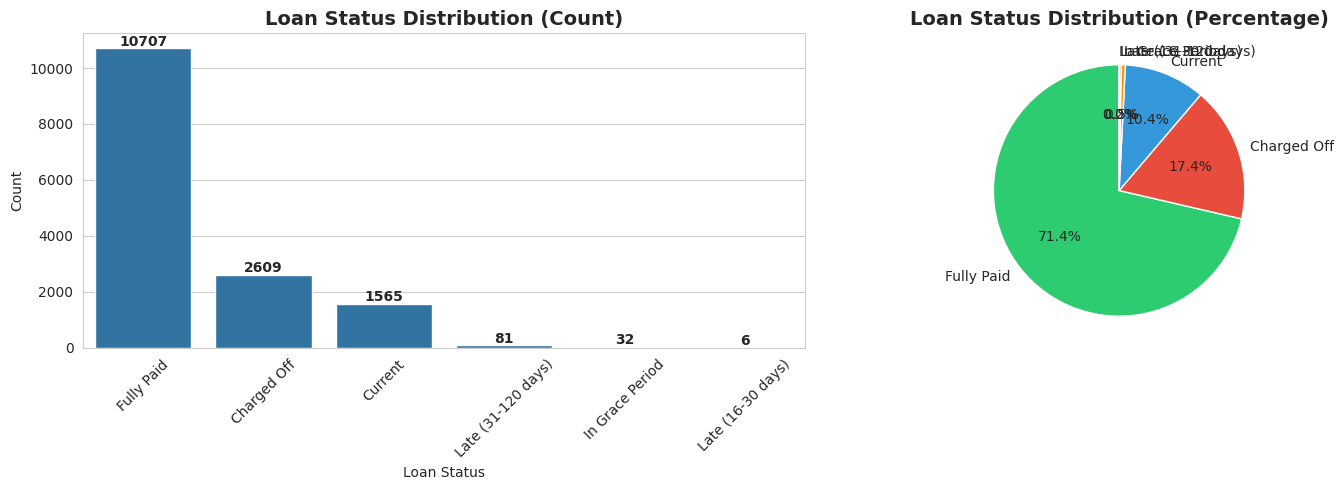


Loan Status Summary:
loan_status
Fully Paid            10707
Charged Off            2609
Current                1565
Late (31-120 days)       81
In Grace Period          32
Late (16-30 days)         6
Name: count, dtype: int64

Percentages:
loan_status
Fully Paid            71.38
Charged Off           17.39
Current               10.43
Late (31-120 days)     0.54
In Grace Period        0.21
Late (16-30 days)      0.04
Name: proportion, dtype: float64


In [ ]:
# Loan status distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Count plot
loan_status_counts = df_subset['loan_status'].value_counts()
sns.barplot(x=loan_status_counts.index, y=loan_status_counts.values, ax=axes[0])
axes[0].set_title('Loan Status Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Loan Status')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
# Add count labels on bars
for i, v in enumerate(loan_status_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6', '#95a5a6']
axes[1].pie(loan_status_counts.values, labels=loan_status_counts.index,
            autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Loan Status Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print statistics
print("\nLoan Status Summary:")
print(loan_status_counts)
print("\nPercentages:")
print(df_subset['loan_status'].value_counts(normalize=True).round(4) * 100)


### Key Observations:
- Majority of loans are **Fully Paid** (~71%)
- **Charged Off** (defaulted) represents ~17% - this is our primary target
- Current loans (~10%) are still in progress
- Small percentage in late payment or grace period status
- **Class imbalance noted** - will need to address in modeling phase

#### Numerical Features Distribution

In [7]:
numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'revol_util']

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px



numerical_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'fico_range_low', 'revol_util']

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=[col.replace('_', ' ').title() for col in numerical_cols],
    vertical_spacing=0.12,
    horizontal_spacing=0.1
)

positions = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2)]

for idx, (col, pos) in enumerate(zip(numerical_cols, positions)):
    data = df_subset[col].dropna()
    mean_val = data.mean()
    median_val = data.median()

    # Histogram
    fig.add_trace(
        go.Histogram(
            x=data,
            name=col,
            nbinsx=50,
            marker_color='lightblue',
            opacity=0.7,
            hovertemplate='Range: %{x}<br>Count: %{y}<extra></extra>',
            showlegend=False
        ),
        row=pos[0], col=pos[1]
    )

    # Mean line
    fig.add_vline(
        x=mean_val,
        line_dash="dash",
        line_color="red",
        annotation_text=f"Mean: {mean_val:.0f}",
        annotation_position="top",
        row=pos[0], col=pos[1]
    )

    # Median line
    fig.add_vline(
        x=median_val,
        line_dash="dash",
        line_color="green",
        annotation_text=f"Median: {median_val:.0f}",
        annotation_position="bottom",
        row=pos[0], col=pos[1]
    )

    fig.update_xaxes(title_text=col.replace('_', ' ').title(), row=pos[0], col=pos[1])
    fig.update_yaxes(title_text="Frequency", row=pos[0], col=pos[1])

fig.update_layout(
    title_text="<b>Numerical Features Distribution</b>",
    title_x=0.5,
    height=900,
    showlegend=False
)

fig.show()

#### Showcasing Outliers

In [12]:
## 4.1 Annual Income Outliers - Interactive

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Boxplot with Outlier', 'Full Distribution', 'Zoomed (<$500K)'),
    column_widths=[0.3, 0.35, 0.35]
)

# Boxplot
fig.add_trace(
    go.Box(
        y=df_subset['annual_inc'],
        name='Annual Income',
        marker_color='lightcoral',
        boxmean=True,
        hovertemplate='Value: $%{y:,.0f}<extra></extra>'
    ),
    row=1, col=1
)

# Full histogram
fig.add_trace(
    go.Histogram(
        x=df_subset['annual_inc'],
        nbinsx=50,
        name='All Data',
        marker_color='skyblue',
        hovertemplate='Income: $%{x:,.0f}<br>Count: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# Add outlier marker
max_income = df_subset['annual_inc'].max()
fig.add_vline(
    x=max_income,
    line_dash="dash",
    line_color="red",
    line_width=2,
    annotation_text=f"Outlier: ${max_income:,.0f}",
    annotation_position="top right",
    row=1, col=2
)

# Zoomed histogram
filtered_income = df_subset[df_subset['annual_inc'] < 500000]['annual_inc']
fig.add_trace(
    go.Histogram(
        x=filtered_income,
        nbinsx=50,
        name='<$500K',
        marker_color='lightgreen',
        hovertemplate='Income: $%{x:,.0f}<br>Count: %{y}<extra></extra>'
    ),
    row=1, col=3
)

fig.update_layout(
    title_text="<b>Annual Income: Outlier Analysis</b>",
    title_x=0.5,
    height=500,
    showlegend=False
)

fig.update_xaxes(title_text="Annual Income ($)", row=1, col=2)
fig.update_xaxes(title_text="Annual Income ($)", row=1, col=3)
fig.update_yaxes(title_text="Frequency", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=1, col=3)

fig.show()

In [14]:
#### DTI Outliers - Interactive

fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=('Boxplot', 'Full Distribution', 'Zoomed (<100%)'),
    column_widths=[0.3, 0.35, 0.35]
)

# Boxplot
fig.add_trace(
    go.Box(
        y=df_subset['dti'],
        name='DTI',
        marker_color='lightyellow',
        boxmean=True
    ),
    row=1, col=1
)

# Add 999 line
fig.add_hline(
    y=999,
    line_dash="dash",
    line_color="red",
    annotation_text="DTI = 999 (placeholder)",
    row=1, col=1
)

# Full histogram
fig.add_trace(
    go.Histogram(
        x=df_subset['dti'],
        nbinsx=50,
        marker_color='orange',
        name='All DTI'
    ),
    row=1, col=2
)

# Zoomed
fig.add_trace(
    go.Histogram(
        x=df_subset[df_subset['dti'] < 100]['dti'],
        nbinsx=50,
        marker_color='lightblue',
        name='DTI <100%'
    ),
    row=1, col=3
)

fig.update_layout(
    title_text="<b>DTI: Outlier Analysis</b>",
    title_x=0.5,
    height=500,
    showlegend=False
)

fig.show()

#### Categorical Features

In [ ]:
# Grade distribution
fig = px.bar(df_subset['grade'].value_counts().sort_index(),
             title='Loan Grade Distribution',
             labels={'index': 'Grade', 'value': 'Count'})
fig.show()

# Purpose
fig = px.bar(df_subset['purpose'].value_counts(),
             title='Loan Purpose Distribution')
fig.show()

# Home ownership
fig = px.bar(df_subset['home_ownership'].value_counts(),
             title='Home Ownership Distribution')
fig.show()

### Correlation Heatmap


In [16]:
import plotly.figure_factory as ff

# Numerical columns only
corr_matrix = df_subset[numerical_cols].corr()

fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    colorscale='RdBu',
    showscale=True
)
fig.update_layout(title='Feature Correlation Heatmap')
fig.show()

#### One key bivariate analysis (default vs features)


In [17]:
# Create binary target: Default (Charged Off) vs Non-Default
df_subset['default'] = df_subset['loan_status'].apply(
    lambda x: 'Default' if x == 'Charged Off' else 'Non-Default'
)

# Compare FICO scores: Default vs Non-Default
fig = px.box(df_subset, x='default', y='fico_range_low',
             title='FICO Score: Defaults vs Non-Defaults',
             color='default')
fig.show()

# Compare interest rates
fig = px.box(df_subset, x='default', y='int_rate',
             title='Interest Rate: Defaults vs Non-Defaults',
             color='default')
fig.show()